
# ResNet Transfer Learning for Histopathologic Cancer Detection

## Imports

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
import tensorflow as tf
from tensorflow.keras.layers import Dropout
import os
from tqdm import tqdm
from shutil import copyfile, move

## Loading Data

In [ ]:
dataset_df = pd.read_csv("../input/histopathologic-cancer-detection/train_labels.csv")
dataset_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0



A label of 1 indicates that cancer cells have been detected. We append the associated filenames for the ids for easy image retrieval.


In [ ]:
dataset_df['label'] = dataset_df['label'].astype("string") # Required in string format for generator later
dataset_df["filename"] = [item.id+".tif" for idx, item in dataset_df.iterrows()]
dataset_df.head()

,id,label,filename
0,f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2,755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4,068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif


## Exploratory Data Analysis (EDA)

In [ ]:
len(dataset_df)

220025

The training data set contains over 220,000 images which is quite substantial. Training sophisticated image classifiers is usually quite resource intensive and some effective strategies will be employed to mitigate this.

Let us check if the data is imbalanced.

In [ ]:
sum(dataset_df['label'] == 0)/len(dataset_df)

0.5949687535507329

Nearly 60% of samples are not cancerous. The data set of images is specifically curated for this task and is not representative of the population sample where incidence of cancer is likely much lower than 40%.  Having closer to a 50-50 balance will be helpful for classification. 

Below are some sample images to show what the convolution neural networks will be learning from. The images are 96 X 96 pixels but a positive label indicates that the center 32 X 32 pixels of the image contain at least one pixel representing cancerous cells. 

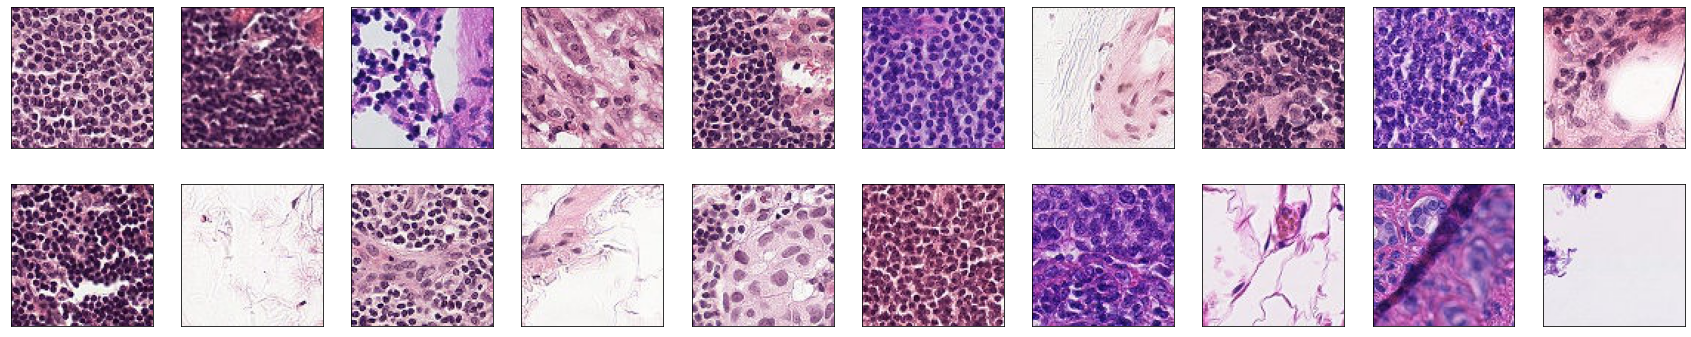

In [ ]:
fig = plt.figure(figsize=(30, 6))
train_imgs = os.listdir("../input/histopathologic-cancer-detection/train/")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("../input/histopathologic-cancer-detection/train/" + img)
    plt.imshow(im)

As the motivation for this classifier is cancer detection, accuracy as a metric is inappropriate as likely this is a screening procedure and a threshold for classification lower than 0.5 would likely lead to additional screening. False negatives are more problematic than false positives. Thus AUC is more appropriate (as is the case in the metric used for this competition) as the accuracy of the relative probabilities themselves are evaluated and not merely compared against a single threshold.  

## ResNet Transfer Learning, Fixed Weights


As the data set is very large, training from scratch would be resource prohibitive and so transfer learning is employed to facilitate the process.

Note that the evaluation metric on the test set being used is the area under the ROC curve (AUC). Though we need a continuous loss function for gradient descent, early stopping on the validation set can be dictated by AUC to  

Also the volatility for any metric being used on the validation set is quit high so early stopping to overfitting is important. For mini-experiments and for a robust validation set, only 20% is initilaly used for trianing which will be increased later when it is more clear which model will be used.

In [ ]:
training_sample_percentage = 0.1
training_sample_size = int(len(dataset_df)*training_sample_percentage)
validation_sample_size = len(dataset_df)-training_sample_size

training_df = dataset_df.sample(n=training_sample_size, random_state = 0)
validation_df = dataset_df[~dataset_df.index.isin(training_df.index)]

In [ ]:
training_batch_size = 128
validation_batch_size = 128
target_size = (96,96)

data_generator = ImageDataGenerator(preprocess_input)

train_generator = data_generator.flow_from_dataframe(
    dataframe = training_df,
    x_col='filename',
    y_col='label',
    directory='../input/histopathologic-cancer-detection/train/',
    target_size=target_size,
    batch_size=training_batch_size,
    shuffle=True,
    class_mode='binary')

validation_generator = data_generator.flow_from_dataframe(
    dataframe = validation_df,
    x_col='filename',
    y_col='label',
    directory='../input/histopathologic-cancer-detection/train/',
    target_size=target_size,
    batch_size=validation_batch_size,
    class_mode='binary')

Found 22002 validated image filenames belonging to 2 classes.
Found 198023 validated image filenames belonging to 2 classes.



Large validation sets are used for overfitting and fast training. When the weights are fixed except for the last layer, a sigmoid activation function is used to convert the output to probabilities between 0 and 1.


In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

num_classes = 1

model1 = Sequential()
model1.add(ResNet50(include_top= False, pooling='max', weights='imagenet'))
model1.add(Dense(num_classes, activation='sigmoid')) # Sigmoid activation for classification.

# Indicate whether the first layer should be trained/changed or not.
model1.layers[0].trainable = False

model1.compile(optimizer='adam', 
               loss='binary_crossentropy', 
               metrics=[AUC(name="auc")])

model1.summary()

2022-12-07 16:13:00.482561: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 16:13:00.619335: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 16:13:00.620106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 16:13:00.621335: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


Note 

In [ ]:
model = ResNet50()
summary = []
for layer, value in zip(model.layers, model.summary()):
 try:
   summary.append(layer.summary())
 except:
   summary.append(value)

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

TypeError: zip argument #2 must support iteration

As binary crossentropy loss and AUC are slightly different measures and the competition is for a good AUC score, early stopping is pegged to a good validation AUC instead of loss. 

In [ ]:
train_step_size = train_generator.n // train_generator.batch_size
epochs = 10

es = EarlyStopping(monitor='val_auc', patience = 2, mode = 'max', restore_best_weights = True)
                   
fit_stats = model1.fit(train_generator,
                       steps_per_epoch=train_step_size,
                       validation_data=validation_generator,
                       validation_steps=1,
                       epochs = epochs,
                       callbacks = [es], 
                       verbose=1)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
2022-12-07 16:16:40.979597: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-12-07 16:16:45.441514: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


171/171 [==============================] - 167s 920ms/step - loss: 0.4982 - auc: 0.8539 - val_loss: 0.5573 - val_auc: 0.8431
Epoch 2/10
171/171 [==============================] - 32s 189ms/step - loss: 0.3853 - auc: 0.9054 - val_loss: 0.3969 - val_auc: 0.9086
Epoch 3/10
171/171 [==============================] - 32s 188ms/step - loss: 0.3604 - auc: 0.9164 - val_loss: 0.2683 - val_auc: 0.9503
Epoch 4/10
171/171 [==============================] - 33s 194ms/step - loss: 0.3426 - auc: 0.9239 - val_loss: 0.3304 - val_auc: 0.9319
Epoch 5/10
171/171 [==============================] - 33s 192ms/step - loss: 0.3275 - auc: 0.9301 - val_loss: 0.3840 - val_auc: 0.9098


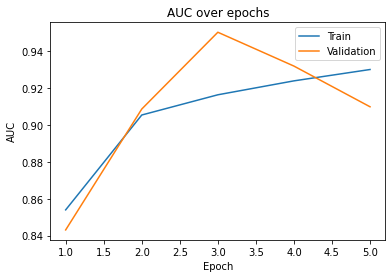

In [ ]:
plt.plot(range(1,len(fit_stats.history['auc']) + 1), fit_stats.history['auc'])
plt.plot(range(1, len(fit_stats.history['auc']) + 1) ,fit_stats.history['val_auc'])
plt.title('AUC over epochs')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

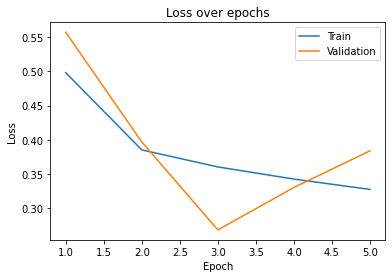

In [ ]:
plt.plot(range(1, len(fit_stats.history['auc']) + 1), fit_stats.history['loss'])
plt.plot(range(1, len(fit_stats.history['auc']) + 1), fit_stats.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [ ]:
training_sample_percentage = 0.2
training_sample_size = int(len(dataset_df)*training_sample_percentage)
validation_sample_size = len(dataset_df)-training_sample_size

training_df = dataset_df.sample(n=training_sample_size, random_state = 0)
validation_df = dataset_df[~dataset_df.index.isin(training_df.index)]

training_batch_size = 128
validation_batch_size = 128
target_size = (96,96)

data_generator = ImageDataGenerator(preprocess_input)

train_generator = data_generator.flow_from_dataframe(
    dataframe = training_df,
    x_col='filename',
    y_col='label',
    directory='../input/histopathologic-cancer-detection/train/',
    target_size=target_size,
    batch_size=training_batch_size,
    shuffle=True,
    class_mode='binary')

validation_generator = data_generator.flow_from_dataframe(
    dataframe = validation_df,
    x_col='filename',
    y_col='label',
    directory='../input/histopathologic-cancer-detection/train/',
    target_size=target_size,
    batch_size=validation_batch_size,
    class_mode='binary')

Found 44005 validated image filenames belonging to 2 classes.
Found 198023 validated image filenames belonging to 2 classes.


In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

num_classes = 1

model2 = Sequential()
model2.add(ResNet50(include_top= False, pooling='max', weights='imagenet'))
model2.add(Dense(num_classes, activation='sigmoid'))

# Indicate whether the first layer should be trained/changed or not.
model2.layers[0].trainable = False

model2.compile(optimizer='adam', 
               loss='binary_crossentropy', 
               metrics=[AUC(name="auc")])

train_step_size = train_generator.n // train_generator.batch_size
epochs = 10

es = EarlyStopping(monitor='val_auc', patience = 2, mode = 'max', restore_best_weights = True)
                   
fit_stats = model2.fit(train_generator2,
                       steps_per_epoch=train_step_size,
                       validation_data=validation_generator2,
                       validation_steps=1,
                       epochs = epochs,
                       callbacks = [es], 
                       verbose=1)

Epoch 1/10
343/343 [==============================] - 173s 496ms/step - loss: 0.4254 - auc: 0.8882 - val_loss: 0.2782 - val_auc: 0.9466
Epoch 2/10
343/343 [==============================] - 60s 176ms/step - loss: 0.3538 - auc: 0.9197 - val_loss: 0.2967 - val_auc: 0.9433
Epoch 3/10
343/343 [==============================] - 60s 176ms/step - loss: 0.3364 - auc: 0.9270 - val_loss: 0.2661 - val_auc: 0.9637
Epoch 4/10
343/343 [==============================] - 61s 178ms/step - loss: 0.3274 - auc: 0.9308 - val_loss: 0.3366 - val_auc: 0.9264
Epoch 5/10
343/343 [==============================] - 60s 174ms/step - loss: 0.3241 - auc: 0.9321 - val_loss: 0.2817 - val_auc: 0.9523


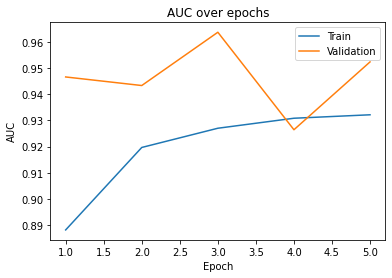

In [ ]:
plt.plot(range(1,len(fit_stats.history['auc']) + 1), fit_stats.history['auc'])
plt.plot(range(1, len(fit_stats.history['auc']) + 1) ,fit_stats.history['val_auc'])
plt.title('AUC over epochs')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

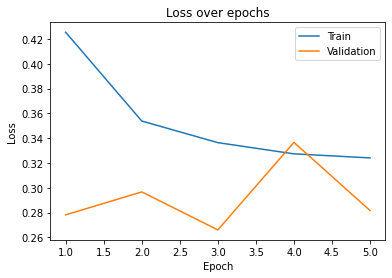

In [ ]:
plt.plot(range(1, len(fit_stats.history['auc']) + 1), fit_stats.history['loss'])
plt.plot(range(1, len(fit_stats.history['auc']) + 1), fit_stats.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [ ]:
training_sample_percentage = 0.3
training_sample_size = int(len(dataset_df)*training_sample_percentage)
validation_sample_size = len(dataset_df)-training_sample_size

training_df = dataset_df.sample(n=training_sample_size, random_state = 0)
validation_df = dataset_df[~dataset_df.index.isin(training_df.index)]

training_batch_size = 128
validation_batch_size = 128
target_size = (96,96)

data_generator = ImageDataGenerator(preprocess_input)

train_generator = data_generator.flow_from_dataframe(
    dataframe = training_df,
    x_col='filename',
    y_col='label',
    directory='../input/histopathologic-cancer-detection/train/',
    target_size=target_size,
    batch_size=training_batch_size,
    shuffle=True,
    class_mode='binary')

validation_generator = data_generator.flow_from_dataframe(
    dataframe = validation_df,
    x_col='filename',
    y_col='label',
    directory='../input/histopathologic-cancer-detection/train/',
    target_size=target_size,
    batch_size=validation_batch_size,
    class_mode='binary')

Found 66007 validated image filenames belonging to 2 classes.
Found 198023 validated image filenames belonging to 2 classes.


In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

num_classes = 1

model3 = Sequential()
model3.add(ResNet50(include_top= False, pooling='max', weights='imagenet'))
model3.add(Dense(num_classes, activation='sigmoid'))

# Indicate whether the first layer should be trained/changed or not.
model3.layers[0].trainable = False

model3.compile(optimizer='adam', 
               loss='binary_crossentropy', 
               metrics=[AUC(name="auc")])

train_step_size = train_generator.n // train_generator.batch_size
epochs = 10

es = EarlyStopping(monitor='val_auc', patience = 2, mode = 'max', restore_best_weights = True)
                   
fit_stats = model3.fit(train_generator3,
                       steps_per_epoch=train_step_size,
                       validation_data=validation_generator3,
                       validation_steps=1,
                       epochs = epochs,
                       callbacks = [es], 
                       verbose=1)

Epoch 1/10
515/515 [==============================] - 197s 377ms/step - loss: 0.4250 - auc: 0.8886 - val_loss: 0.4204 - val_auc: 0.8961
Epoch 2/10
515/515 [==============================] - 89s 172ms/step - loss: 0.3499 - auc: 0.9214 - val_loss: 0.3409 - val_auc: 0.9252
Epoch 3/10
515/515 [==============================] - 89s 173ms/step - loss: 0.3343 - auc: 0.9277 - val_loss: 0.4735 - val_auc: 0.8933
Epoch 4/10
515/515 [==============================] - 90s 175ms/step - loss: 0.3275 - auc: 0.9308 - val_loss: 0.3135 - val_auc: 0.9346
Epoch 5/10
515/515 [==============================] - 90s 174ms/step - loss: 0.3256 - auc: 0.9318 - val_loss: 0.3226 - val_auc: 0.9318
Epoch 6/10
515/515 [==============================] - 88s 171ms/step - loss: 0.3211 - auc: 0.9335 - val_loss: 0.3980 - val_auc: 0.9008


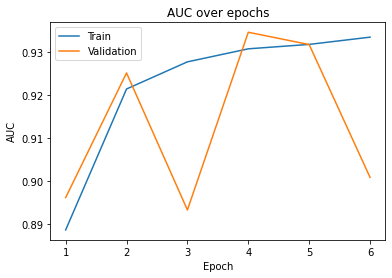

In [ ]:
plt.plot(range(1,len(fit_stats.history['auc']) + 1), fit_stats.history['auc'])
plt.plot(range(1, len(fit_stats.history['auc']) + 1) ,fit_stats.history['val_auc'])
plt.title('AUC over epochs')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

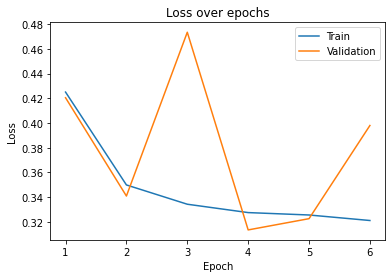

In [ ]:
plt.plot(range(1, len(fit_stats.history['auc']) + 1), fit_stats.history['loss'])
plt.plot(range(1, len(fit_stats.history['auc']) + 1), fit_stats.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

The metrics of the restored best weights in each of the three runs is summarized below.

|Training Data (%)|AUC (Train)| AUC (Validation)| BCE Loss (Train)| BCE Loss (Validation)
|:----|:----|:----|:----|:--------:|
|10|0.9164|0.9503|0.3604|0.2683|
|20|0.9270 |0.9637|0.3364|0.2661 |
|30|0.9308|0.9346|0.3275 |0.3135|

The second column ("AUC (Validation)") is the metric of interest and shows that using 20% of the training data for fitting and the remainder for validation leads to the highest AUC of 0.9637 on the validation data set. Using additional training data for fitting did not lead to improvements but the AUC over epochs is quite noisy.

## ResNet Transfer Learning, Learned Weights

In [ ]:
training_batch_size = 128
validation_batch_size = 128
target_size = (96,96)

data_generator = ImageDataGenerator(preprocess_input)

train_generator = data_generator.flow_from_dataframe(
    dataframe = training_df,
    x_col='filename',
    y_col='label',
    directory='../input/histopathologic-cancer-detection/train/',
    target_size=target_size,
    batch_size=training_batch_size,
    shuffle=True,
    class_mode='binary')

validation_generator = data_generator.flow_from_dataframe(
    dataframe = validation_df,
    x_col='filename',
    y_col='label',
    directory='../input/histopathologic-cancer-detection/train/',
    target_size=target_size,
    batch_size=validation_batch_size,
    class_mode='binary')

Found 22002 validated image filenames belonging to 2 classes.
Found 198023 validated image filenames belonging to 2 classes.


In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

num_classes = 1

model4 = Sequential()
model4.add(ResNet50(include_top= False, pooling='max', weights='imagenet'))
model4.add(Dense(num_classes, activation='sigmoid'))

# Indicate whether the first layer should be trained/changed or not.
model4.layers[0].trainable = True

model4.compile(optimizer='adam', 
               loss='binary_crossentropy', 
               metrics=[AUC(name="auc")])

model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


As can be seen now, most parameters are trainable unlike before where only the last dense layer had weights adjusted via backpropagation.

In [ ]:
train_step_size = train_generator.n // train_generator.batch_size
epochs = 10

es = EarlyStopping(monitor='val_auc', patience = 2, mode = 'max', restore_best_weights = True)
                   
fit_stats = model4.fit(train_generator,
                       steps_per_epoch=train_step_size,
                       validation_data=validation_generator,
                       validation_steps=1,
                       epochs = epochs,
                       callbacks = [es], 
                       verbose=1)

Epoch 1/10
171/171 [==============================] - 43s 226ms/step - loss: 0.5702 - auc: 0.8954 - val_loss: 341.7715 - val_auc: 0.5919
Epoch 2/10
171/171 [==============================] - 37s 213ms/step - loss: 0.3167 - auc: 0.9448 - val_loss: 0.3218 - val_auc: 0.9538
Epoch 3/10
171/171 [==============================] - 39s 225ms/step - loss: 0.2386 - auc: 0.9676 - val_loss: 0.4725 - val_auc: 0.8913
Epoch 4/10
171/171 [==============================] - 38s 221ms/step - loss: 0.2387 - auc: 0.9714 - val_loss: 0.5798 - val_auc: 0.8649


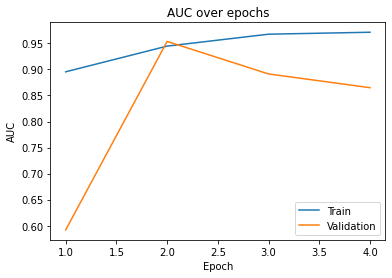

In [ ]:
plt.plot(range(1,len(fit_stats.history['auc']) + 1), fit_stats.history['auc'])
plt.plot(range(1, len(fit_stats.history['auc']) + 1) ,fit_stats.history['val_auc'])
plt.title('AUC over epochs')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

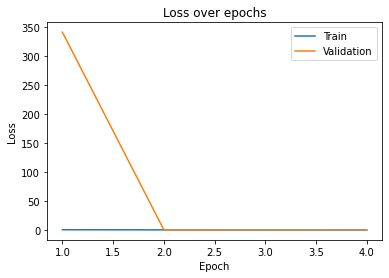

In [ ]:
plt.plot(range(1, len(fit_stats.history['auc']) + 1), fit_stats.history['loss'])
plt.plot(range(1, len(fit_stats.history['auc']) + 1), fit_stats.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [ ]:
training_sample_percentage = 0.2
training_sample_size = int(len(dataset_df)*training_sample_percentage)
validation_sample_size = len(dataset_df)-training_sample_size

training_df = dataset_df.sample(n=training_sample_size, random_state = 0)
validation_df = dataset_df[~dataset_df.index.isin(training_df.index)]

training_batch_size = 128
validation_batch_size = 128
target_size = (96,96)

data_generator = ImageDataGenerator(preprocess_input)

train_generator = data_generator.flow_from_dataframe(
    dataframe = training_df,
    x_col='filename',
    y_col='label',
    directory='../input/histopathologic-cancer-detection/train/',
    target_size=target_size,
    batch_size=training_batch_size,
    shuffle=True,
    class_mode='binary')

validation_generator = data_generator.flow_from_dataframe(
    dataframe = validation_df,
    x_col='filename',
    y_col='label',
    directory='../input/histopathologic-cancer-detection/train/',
    target_size=target_size,
    batch_size=validation_batch_size,
    class_mode='binary')

Found 44005 validated image filenames belonging to 2 classes.
Found 198023 validated image filenames belonging to 2 classes.


In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

num_classes = 1

model5 = Sequential()
model5.add(ResNet50(include_top= False, pooling='max', weights='imagenet'))
model5.add(Dense(num_classes, activation='sigmoid'))

# Indicate whether the first layer should be trained/changed or not.
model5.layers[0].trainable = True

model5.compile(optimizer='adam', 
               loss='binary_crossentropy', 
               metrics=[AUC(name="auc")])

train_step_size = train_generator.n // train_generator.batch_size
epochs = 10

es = EarlyStopping(monitor='val_auc', patience = 2, mode = 'max', restore_best_weights = True)
                   
fit_stats = model5.fit(train_generator,
                       steps_per_epoch=train_step_size,
                       validation_data=validation_generator,
                       validation_steps=1,
                       epochs = epochs,
                       callbacks = [es], 
                       verbose=1)

Epoch 1/10
343/343 [==============================] - 76s 208ms/step - loss: 0.4851 - auc: 0.9196 - val_loss: 0.8352 - val_auc: 0.7813
Epoch 2/10
343/343 [==============================] - 70s 204ms/step - loss: 0.3845 - auc: 0.9262 - val_loss: 0.9779 - val_auc: 0.8840
Epoch 3/10
343/343 [==============================] - 69s 202ms/step - loss: 0.3212 - auc: 0.9412 - val_loss: 0.5377 - val_auc: 0.9392
Epoch 4/10
343/343 [==============================] - 70s 204ms/step - loss: 0.2378 - auc: 0.9627 - val_loss: 0.2995 - val_auc: 0.9584
Epoch 5/10
343/343 [==============================] - 70s 204ms/step - loss: 0.2067 - auc: 0.9715 - val_loss: 0.4293 - val_auc: 0.8613
Epoch 6/10
343/343 [==============================] - 69s 200ms/step - loss: 0.3221 - auc: 0.9393 - val_loss: 0.7752 - val_auc: 0.6743


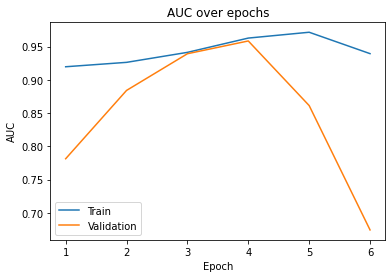

In [ ]:
plt.plot(range(1,len(fit_stats.history['auc']) + 1), fit_stats.history['auc'])
plt.plot(range(1, len(fit_stats.history['auc']) + 1) ,fit_stats.history['val_auc'])
plt.title('AUC over epochs')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

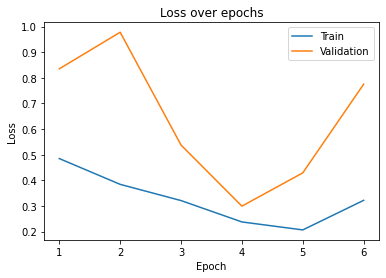

In [ ]:
plt.plot(range(1, len(fit_stats.history['auc']) + 1), fit_stats.history['loss'])
plt.plot(range(1, len(fit_stats.history['auc']) + 1), fit_stats.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [ ]:
training_sample_percentage = 0.3
training_sample_size = int(len(dataset_df)*training_sample_percentage)
validation_sample_size = len(dataset_df)-training_sample_size

training_df = dataset_df.sample(n=training_sample_size, random_state = 0)
validation_df = dataset_df[~dataset_df.index.isin(training_df.index)]

training_batch_size = 128
validation_batch_size = 128
target_size = (96,96)

data_generator = ImageDataGenerator(preprocess_input)

train_generator = data_generator.flow_from_dataframe(
    dataframe = training_df,
    x_col='filename',
    y_col='label',
    directory='../input/histopathologic-cancer-detection/train/',
    target_size=target_size,
    batch_size=training_batch_size,
    shuffle=True,
    class_mode='binary')

validation_generator = data_generator.flow_from_dataframe(
    dataframe = validation_df,
    x_col='filename',
    y_col='label',
    directory='../input/histopathologic-cancer-detection/train/',
    target_size=target_size,
    batch_size=validation_batch_size,
    class_mode='binary')

Found 66007 validated image filenames belonging to 2 classes.
Found 198023 validated image filenames belonging to 2 classes.


In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

num_classes = 1

model6 = Sequential()
model6.add(ResNet50(include_top= False, pooling='max', weights='imagenet'))
model6.add(Dense(num_classes, activation='sigmoid'))

# Indicate whether the first layer should be trained/changed or not.
model6.layers[0].trainable = True

model6.compile(optimizer='adam', 
               loss='binary_crossentropy', 
               metrics=[AUC(name="auc")])

train_step_size = train_generator.n // train_generator.batch_size
epochs = 10

es = EarlyStopping(monitor='val_auc', patience = 2, mode = 'max', restore_best_weights = True)
                   
fit_stats = model6.fit(train_generator,
                       steps_per_epoch=train_step_size,
                       validation_data=validation_generator,
                       validation_steps=1,
                       epochs = epochs,
                       callbacks = [es], 
                       verbose=1)

Epoch 1/10
515/515 [==============================] - 109s 201ms/step - loss: 0.4818 - auc: 0.9016 - val_loss: 1.4002 - val_auc: 0.8689
Epoch 2/10
515/515 [==============================] - 104s 202ms/step - loss: 0.2652 - auc: 0.9558 - val_loss: 0.7622 - val_auc: 0.8607
Epoch 3/10
515/515 [==============================] - 101s 195ms/step - loss: 0.2580 - auc: 0.9634 - val_loss: 1.2562 - val_auc: 0.7297


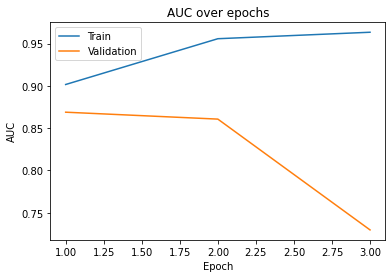

In [ ]:
plt.plot(range(1,len(fit_stats.history['auc']) + 1), fit_stats.history['auc'])
plt.plot(range(1, len(fit_stats.history['auc']) + 1) ,fit_stats.history['val_auc'])
plt.title('AUC over epochs')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

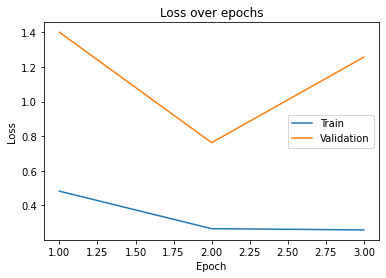

In [ ]:
plt.plot(range(1, len(fit_stats.history['auc']) + 1), fit_stats.history['loss'])
plt.plot(range(1, len(fit_stats.history['auc']) + 1), fit_stats.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

The metrics of the restored best weights in each of the three runs is summarized below.

|Training Data (%)|AUC (Train)| AUC (Validation)| BCE Loss (Train)| BCE Loss (Validation)
|:----|:----|:----|:----|:--------:|
|10|0.9448|0.9538|0.3167|0.3218|
|20|0.9627|0.9584|0.2378|0.2995|
|30|0.9016|0.8689|0.4818|1.4002|

The second column ("AUC (Validation)") is the metric of interest and shows that using 20% of the training data for fitting and the remainder for validation leads to the highest AUC of 0.9584 on the validation data set. Using additional training data for fitting did not lead to improvements but the AUC over epochs is quite noisy.

## Results Summary

The below code is used to load the test images and ensure that predictions are assigned to the matching imges

In [ ]:
src="../input/histopathologic-cancer-detection/test"

test_folder="../test_folder"
dst = test_folder+"/test"
os.mkdir(test_folder)
os.mkdir(dst)

file_list =  os.listdir(src)
with tqdm(total=len(file_list)) as pbar:
    for filename in file_list:
        pbar.update(1)
        copyfile(src+"/"+filename,dst+"/"+filename)

100%|██████████| 57458/57458 [07:23<00:00, 129.45it/s]


In [ ]:
test_generator = data_generator.flow_from_directory(
    directory=test_folder,
    target_size=target_size,
    shuffle=False,
    class_mode='binary'
)

Found 57458 images belonging to 1 classes.


In [ ]:
pred = model2.predict(test_generator,verbose=1)

1796/1796 [==============================] - 62s 34ms/step


In [ ]:
pred2 = model5.predict(test_generator,verbose=1)

1796/1796 [==============================] - 54s 30ms/step


In [ ]:
#pred = model2.predict(test_generator,verbose=1)

csv_file = open("sample_submission.csv","w")
csv_file.write("id,label\n")
for filename, prediction in zip(test_generator.filenames,pred):
    name = filename.split("/")[1].replace(".tif","")
    csv_file.write(str(name)+","+str(prediction[0])+"\n")
csv_file.close()

In [ ]:
sub = pd.read_csv('./sample_submission.csv')
sub.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0.473602
1,0000ec92553fda4ce39889f9226ace43cae3364e,0.982265
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.845493
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0.960547
4,000270442cc15af719583a8172c87cd2bd9c7746,0.049435


In [ ]:
csv_file = open("sample_submission.csv","w")
csv_file.write("id,label\n")
for filename, prediction in zip(test_generator.filenames,pred2):
    name = filename.split("/")[1].replace(".tif","")
    csv_file.write(str(name)+","+str(prediction[0])+"\n")
csv_file.close()

In [ ]:
sub2 = pd.read_csv('./sample_submission.csv')
sub2.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,9.982020e-01
1,0000ec92553fda4ce39889f9226ace43cae3364e,9.902524e-01
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,9.559646e-01
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,8.609114e-01
4,000270442cc15af719583a8172c87cd2bd9c7746,1.549771e-36


 The above two sets of predicted probabilities are submitted on Kaggle to determine the AUC on the test set (which is subdivided relatively evenly into public and private test sets).

|Model|Training Data (%)| AUC (Test Public)| AUC (Test Private)|
|:----|:----|:----|:--------:|
|ResNet Fixed Weights|20|0.9034|0.8878|
|ResNet Trained Weights|20|0.9372|0.9204|

 Of the two models fit to the test data, the latter one with the ResNet architecture learning the weights performs better. Recall only 20% of the training data was used for both of these models and the same implementation of both processes with fitting to 30% of the training data did not lead to improved results on the validation data.

Training is quite unstable - could consider lowering the learning rate but length of time required to train would be substantial. Same with increasing training data %. Right fix of avoiding overfitting but increasing model complexity is tough.

Training, even for the learned weights implementation, is able to run in minutes per epoch and only a few epochs are required due to early stopping to prevent overfitting. 
